In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('seaborn')
import warnings
warnings.simplefilter("ignore")
from xgboost import XGBClassifier

import numpy as np

def ACCURACY(true, pred):   
    score = np.mean(true==pred)
    return score

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/income_pred/test.csv')
train = pd.read_csv('/content/drive/MyDrive/income_pred/train.csv')

In [ ]:
test.head()

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,47,Private,304133,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
1,1,34,Self-emp-inc,154227,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,75,United-States
2,2,31,Local-gov,158291,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,8614,0,40,United-States
3,3,28,Private,183155,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States
4,4,54,Local-gov,182543,Some-college,10,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,Mexico


In [ ]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 있는 컬럼은: workclass 입니다
해당 컬럼에 총 1836 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: occupation 입니다
해당 컬럼에 총 1843 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: native.country 입니다
해당 컬럼에 총 583 개의 결측치가 존재합니다.


In [ ]:
# 결측치를 처리하는 함수를 작성합니다.
def handle_na(data, missing_col):
    temp = data.copy()
    for col, dtype in missing_col:
        if dtype == 'O':
            # 범주형 feature가 결측치인 경우 해당 행들을 삭제해 주었습니다.
            temp = temp.dropna(subset=[col])
    return temp

train = handle_na(train, missing_col)

# 결측치 처리가 잘 되었는지 확인해 줍니다.
missing_col = check_missing_col(train) 

결측치가 존재하지 않습니다


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15081 entries, 0 to 15080
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15081 non-null  int64 
 1   age             15081 non-null  int64 
 2   workclass       15081 non-null  object
 3   fnlwgt          15081 non-null  int64 
 4   education       15081 non-null  object
 5   education.num   15081 non-null  int64 
 6   marital.status  15081 non-null  object
 7   occupation      15081 non-null  object
 8   relationship    15081 non-null  object
 9   race            15081 non-null  object
 10  sex             15081 non-null  object
 11  capital.gain    15081 non-null  int64 
 12  capital.loss    15081 non-null  int64 
 13  hours.per.week  15081 non-null  int64 
 14  native.country  15081 non-null  object
 15  target          15081 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 2.0+ MB


In [ ]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            #dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

train = label_encoder(train, make_label_map(train))

In [ ]:
train

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,0,32,0,309513,0,12,0,0,0,0,0,0,0,40,0,0
1,1,33,0,205469,1,10,0,1,0,0,0,0,0,40,0,1
2,2,46,0,149949,1,10,0,0,0,0,0,0,0,40,0,0
3,3,23,0,193090,2,13,1,2,1,0,1,0,0,30,0,0
4,4,55,0,60193,3,9,2,2,2,0,1,0,0,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,15076,35,0,337286,7,14,1,1,2,2,0,0,0,40,0,0
15077,15077,36,0,182074,1,10,2,2,2,0,0,0,0,45,0,0
15078,15078,50,4,175070,4,15,0,3,0,0,0,0,0,45,0,1
15079,15079,39,0,202937,1,10,2,10,2,0,1,0,0,40,1,0


In [ ]:
train.drop(['id'], axis = 1, inplace=True)
test.drop(['id'], axis = 1, inplace=True)

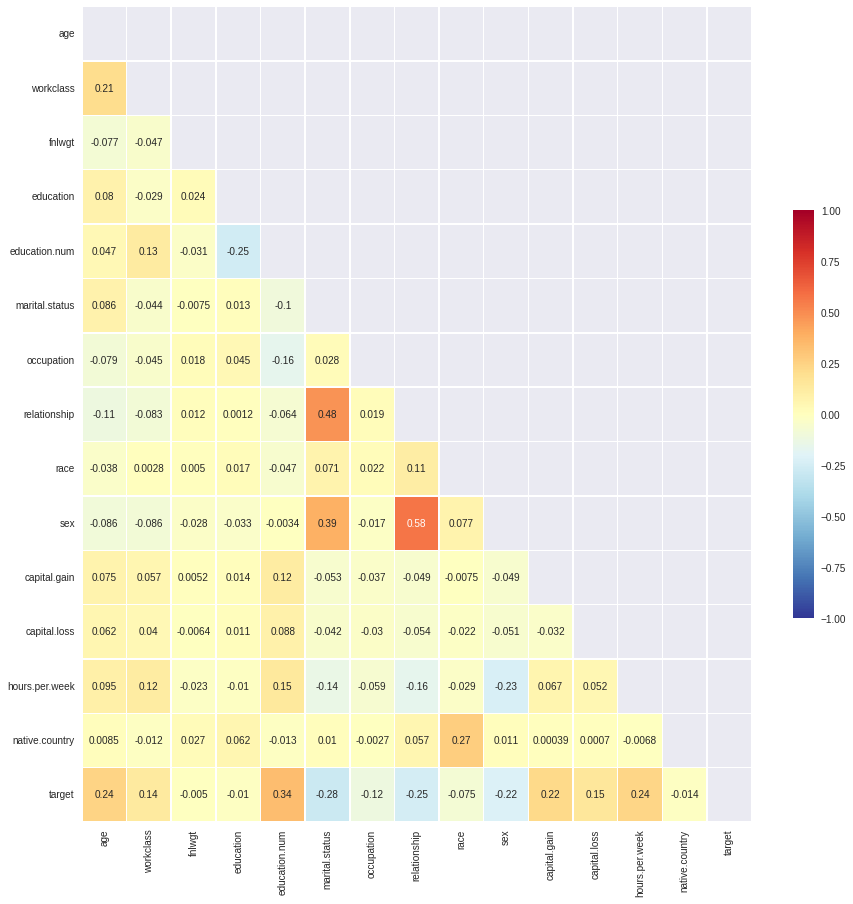

In [ ]:
df=train.corr()
fig, ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df,
            cmap = 'RdYlBu_r',
            annot = True,   
            mask=mask,     
            linewidths=.5,  
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1
           )  
plt.show()

In [ ]:
train.drop(['workclass', 'fnlwgt', 'race','native.country'], axis=1, inplace=True)

test.drop(['workclass', 'fnlwgt', 'race','native.country'], axis=1, inplace=True)


In [ ]:
test = label_encoder(test, make_label_map(test))
test.head()

,age,education,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week
0,47,0,10,0,0,0,0,0,0,45
1,34,0,10,1,1,1,0,0,0,75
2,31,1,13,1,2,1,0,8614,0,40
3,28,1,13,0,3,0,0,0,0,55
4,54,0,10,2,4,2,1,0,0,40


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,5)).fit(X_train)
X_train= minmax_scale.transform(X_train)
X_train.shape

(15081, 14)

In [ ]:
X_train

array([[1.02739726, 0.        , 1.01170953, ..., 0.        , 1.98979592,
        0.        ],
       [1.09589041, 0.        , 0.64959265, ..., 0.        , 1.98979592,
        0.        ],
       [1.98630137, 0.        , 0.4563597 , ..., 0.        , 1.98979592,
        0.        ],
       ...,
       [2.26027397, 3.33333333, 0.54379135, ..., 0.        , 2.24489796,
        0.        ],
       [1.50684932, 0.        , 0.64078023, ..., 0.        , 1.98979592,
        0.125     ],
       [1.09589041, 0.        , 0.2694472 , ..., 0.        , 2.5       ,
        0.        ]])

In [ ]:
import numpy as np

def ACCURACY(true, pred):   
    score = np.mean(true==pred)
    return score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rc_clf = RandomForestClassifier(n_estimators = 400, max_depth = 3, random_state=156)
# DecisionTreeClassifier 학습
rc_clf.fit(X_train, y_train)
prediction = rc_clf.predict(test)

score = ACCURACY(y_train, prediction)

print(f"모델의 정확도는 {score*100:.2f}% 입니다")



ValueError: ignored

Feature Importance: [0.078 0.004 0.    0.007 0.149 0.223 0.024 0.207 0.001 0.028 0.196 0.025
 0.057 0.001]


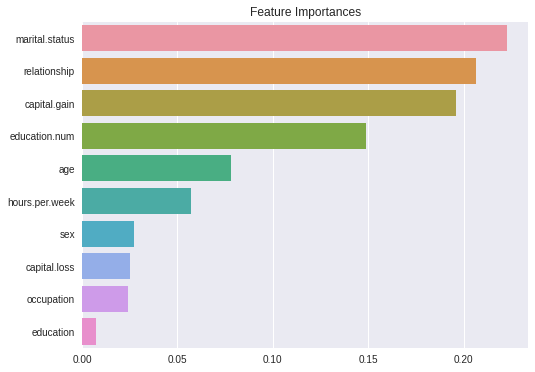

In [ ]:
feature_importance_values = rc_clf.feature_importances_
print(f"Feature Importance: {np.round(rc_clf.feature_importances_, 3)}")
feature_importances = pd.Series(feature_importance_values, index = X_train.columns)
feature_top10 = feature_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=[8,6])
plt.title('Feature Importances')
sns.barplot(x=feature_top10, y=feature_top10.index)
plt.show()

In [ ]:
X_train=X_train[['marital.status','relationship','capital.gain','education.num', 'age', 'hours.per.week', 'sex', 'capital.loss', 'occupation', 'education']]
test=test[['marital.status','relationship','capital.gain','education.num', 'age', 'hours.per.week', 'sex', 'capital.loss', 'occupation', 'education']]



In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [ 6, 8, 10, 12, 16, 20, 24]
         }

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8442
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 8}


In [ ]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.843976
1,8,0.844175
2,10,0.840992
3,12,0.834361
4,16,0.817585
5,20,0.807042
6,24,0.801671


In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators':[100,500],'learning_rate':[0.05,0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print(' 최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.5min finished


 최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 500}
최고 예측 정확도:0.8647


In [ ]:
prediction = grid_cv.predict(test)
prediction

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
!pip install pycaret

In [ ]:
!pip install scikit-learn --user --upgrade

In [ ]:
  pip install --upgrade scikit-learn==0.23.2

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.3.10 requires scipy<=1.5.4, but you have scipy 1.7.3 which is incompatible.


In [ ]:
prediction = xgb_clt.predict(test)
prediction

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:

from pycaret.regression import *
clf1 = setup(data = train,
             silent = True,
             target = 'target',
             session_id = 20201809,
             n_jobs = 7)


,Description,Value
0,session_id,20201809
1,Target,target
2,Original Data,"(15081, 11)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10556, 48)"


In [ ]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.1963,0.0965,0.3105,0.4873,0.2182,0.3834,1.070
gbr,Gradient Boosting Regressor,0.2194,0.1004,0.3168,0.4668,0.2224,0.4278,0.931
rf,Random Forest Regressor,0.1988,0.1175,0.3427,0.3760,0.2417,0.3797,2.843
ridge,Ridge Regression,0.2703,0.1197,0.3459,0.3641,0.2453,0.4881,0.020
lar,Least Angle Regression,0.2703,0.1197,0.3459,0.3641,0.2453,0.4879,0.038
br,Bayesian Ridge,0.2705,0.1197,0.3459,0.3641,0.2452,0.4899,0.057
lr,Linear Regression,0.2702,0.1200,0.3463,0.3627,0.2456,0.4863,1.106
knn,K Neighbors Regressor,0.2073,0.1215,0.3484,0.3548,0.2473,0.3877,0.420
ada,AdaBoost Regressor,0.3038,0.1310,0.3618,0.3043,0.2639,0.4655,0.288
omp,Orthogonal Matching Pursuit,0.2720,0.1341,0.3661,0.2879,0.2576,0.5476,0.020


In [ ]:
best= compare_models(n_select=3, fold = 10) #상위 모델 3개를 선택합니다

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.1963,0.0965,0.3105,0.4873,0.2182,0.3834,0.955
gbr,Gradient Boosting Regressor,0.2194,0.1004,0.3168,0.4668,0.2224,0.4278,0.937
rf,Random Forest Regressor,0.1988,0.1175,0.3427,0.3760,0.2417,0.3797,2.952
ridge,Ridge Regression,0.2703,0.1197,0.3459,0.3641,0.2453,0.4881,0.031
lar,Least Angle Regression,0.2703,0.1197,0.3459,0.3641,0.2453,0.4879,0.040
br,Bayesian Ridge,0.2705,0.1197,0.3459,0.3641,0.2452,0.4899,0.056
lr,Linear Regression,0.2702,0.1200,0.3463,0.3627,0.2456,0.4863,0.038
knn,K Neighbors Regressor,0.2073,0.1215,0.3484,0.3548,0.2473,0.3877,0.401
ada,AdaBoost Regressor,0.3038,0.1310,0.3618,0.3043,0.2639,0.4655,0.284
omp,Orthogonal Matching Pursuit,0.2720,0.1341,0.3661,0.2879,0.2576,0.5476,0.031


In [ ]:
blend_3_soft = blend_models(estimator_list=best, choose_better = True)
predict_model(blend_3_soft).head(10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1996,0.0953,0.3087,0.4942,0.2163,0.3917
1,0.1992,0.0987,0.3141,0.4477,0.2234,0.3964
2,0.2007,0.0963,0.3103,0.4990,0.2176,0.3887
3,0.2035,0.0978,0.3128,0.4872,0.2208,0.3821
4,0.2024,0.0995,0.3155,0.4678,0.2225,0.3949
5,0.2109,0.1072,0.3274,0.4409,0.2296,0.4133
6,0.2104,0.1036,0.3218,0.4627,0.2239,0.4184
7,0.1977,0.0927,0.3045,0.4771,0.2186,0.3610
8,0.1952,0.0935,0.3058,0.5088,0.2129,0.3929


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1983,0.097,0.3114,0.4774,0.2199,0.3802


,age,capital.gain,capital.loss,hours.per.week,education_0,education_1,education_10,education_11,education_14,education_2,...,occupation_9,relationship_0,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,sex_1,target,Label
0,30.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.002346
1,26.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.055879
2,38.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.812516
3,41.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0.791893
4,33.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.601188
5,30.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.346038
6,29.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.026829
7,50.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.283926
8,38.0,0.0,0.0,50.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.665407
9,40.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.178101


In [ ]:
final_blend_3_soft = finalize_model(blend_3_soft)
prediction = predict_model(final_blend_3_soft, data = test)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/income_pred/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
print(prediction["Label"])

0        0.420612
1        0.154406
2        0.959380
3        0.386313
4        0.018940
           ...   
15076    0.951034
15077    0.458835
15078    0.072442
15079    0.664323
15080    0.081670
Name: Label, Length: 15081, dtype: float64


In [ ]:
submission['target'] = prediction['Label']
submission.head()

,id,target
0,0,0.420612
1,1,0.154406
2,2,0.959380
3,3,0.386313
4,4,0.018940


In [ ]:
submission['target'] = prediction

ValueError: ignored

In [ ]:
submission

,id,target
0,0,0.420612
1,1,0.154406
2,2,0.959380
3,3,0.386313
4,4,0.018940
...,...,...
15076,15076,0.951034
15077,15077,0.458835
15078,15078,0.072442
15079,15079,0.664323


In [ ]:
submission.to_csv('submit_6.csv', index=False)